In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-6umb2loj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-6umb2loj
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=2d12485f406477bef2f295c73ea2bea670bcf7344bcc8d564ad11744af2afa8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmix7y6h/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import glob
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path='/content/drive/My Drive/summer2winter'
train_A_paths = glob.glob(path+'/trainA/*.jpg')
train_B_paths = glob.glob(path+'/trainB/*.jpg')
print('Number of summer images train：',len(train_A_paths))
print('Number of winter images train：',len(train_B_paths))

test_A_paths = glob.glob(path+'/testA/*.jpg')
test_B_paths = glob.glob(path+'/testB/*.jpg')
print('Number of summer images test：',len(test_A_paths))
print('Number of winter images test：',len(test_B_paths))

Number of summer images train： 1231
Number of winter images train： 962
Number of summer images test： 309
Number of winter images test： 238


In [5]:
size = 256

# read and load an image with 256x256 size and rgb color mode
def read_img(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=(size, size))
    return img


def prepare_dataset(namelist):
    start = time.time()

    imgs_list = []


    with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:


        for img in executor.map(read_img, namelist):
              imgs_list.append(img)  # append the loaded image to imgs list


    imgs = np.stack(imgs_list)
    imgs = tf.convert_to_tensor(imgs) #convert to tensorflow tensor


    return imgs


In [6]:
with tf.device('/cpu:0'):
    train_a= prepare_dataset(train_A_paths)
    train_b= prepare_dataset(train_B_paths)
    test_a= prepare_dataset(test_A_paths)
    test_b= prepare_dataset(test_B_paths)
print("Summer train shape", train_a.shape)
print("Winter train shape", train_b.shape)
print("Summer test shape", test_a.shape)
print("Winter test shape", test_b.shape)

Summer train shape (1231, 256, 256, 3)
Winter train shape (962, 256, 256, 3)
Summer test shape (309, 256, 256, 3)
Winter test shape (238, 256, 256, 3)


In [7]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [11]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [12]:
def preprocess_image_train(image,):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [13]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [14]:
train_a = train_a.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_b = train_b.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_a = test_a.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_b = test_b.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [39]:
sample_summer = next(iter(train_a))
sample_winter = next(iter(train_b))

In [17]:
train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

In [19]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [21]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [22]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [23]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [24]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
EPOCHS = 10

In [29]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Summer Image', 'Generated Winter Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # pixel values to [0, 1].
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [30]:
@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:
    # Generator G :X -> Y
    # Generator F :Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)


    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)


  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

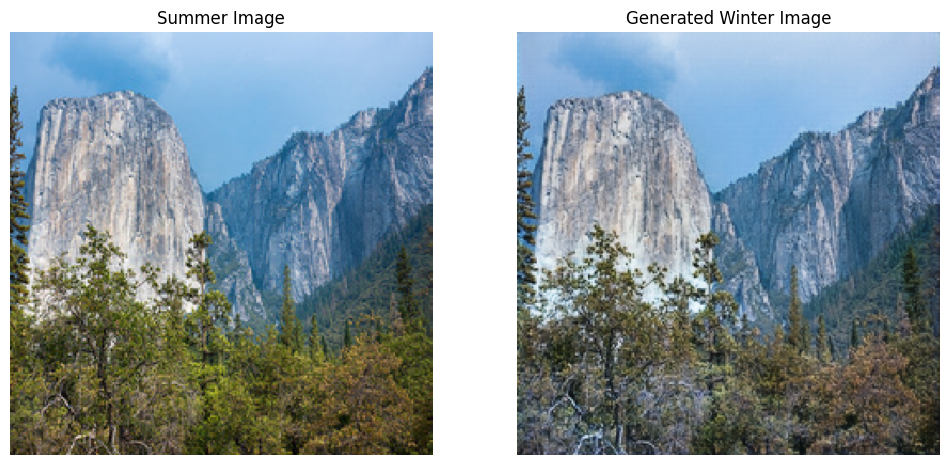

Time taken for epoch 10 is 431.2652699947357 sec



In [41]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in train_dataset:
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)

  generate_images(generator_g, sample_summer)


  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))